<a href="https://colab.research.google.com/github/GrzegorzPiedel/portfolio/blob/main/Bitcoin%20prices%20prediction%20in%20time.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()

import os
os.listdir()

Saving bitcoin.csv to bitcoin.csv


['.config', 'bitcoin.csv', 'sample_data']

In [ ]:
import pandas as pd
import numpy as np

bitcoin = pd.read_csv('bitcoin.csv', parse_dates=True, dayfirst=True, index_col="date")
bitcoin['value'] = pd.to_numeric(bitcoin['value'].str.replace(",", "."))

bitcoin['year'] = bitcoin.index.year
bitcoin['month'] = bitcoin.index.month
bitcoin['day'] = bitcoin.index.day
bitcoin['weekday'] = bitcoin.index.weekday

bitcoin['month_sin'] = np.sin(2 * np.pi * bitcoin['month'] / 12)
bitcoin['month_cos'] = np.cos(2 * np.pi * bitcoin['month'] / 12)
bitcoin['weekday_sin'] = np.sin(2 * np.pi * bitcoin['weekday'] / 7)
bitcoin['weekday_cos'] = np.cos(2 * np.pi * bitcoin['weekday'] / 7)

for lag in [1, 3, 7, 14]:
    bitcoin[f'value_lag_{lag}'] = bitcoin["value"].shift(lag)
    bitcoin[f'value_roll_mean_{lag}'] = bitcoin['value'].rolling(window=lag).mean().shift(lag)

bitcoin.dropna(inplace=True)

from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

X = bitcoin.drop(columns="value")
y = bitcoin["value"]

ts_split = TimeSeriesSplit(n_splits=5)

models = {
    'LinearRegression': LinearRegression(),
    'Lasso (alpha: 0.1)': Lasso(alpha=0.1, random_state=42),
    'SVR': SVR(C=3, kernel='rbf', epsilon=0.1),
    'KNeighbors': KNeighborsRegressor(n_neighbors=5, weights='distance'),
    'XGBoost': XGBRegressor(max_depth=4, subsample=0.8, random_state=42),
    'RandomForest': RandomForestRegressor(max_depth=4, random_state=42)
}

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

results = {name: {"R²": [], "MAE": [], "RMSE": []} for name in models}
predictions = {name: [] for name in models}

scaler = StandardScaler()

for name, model in models.items():
    for i, (train_index, test_index) in enumerate(ts_split.split(X)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        if i == 0:
            X_train_scaled = scaler.fit_transform(X_train)
        else:
            X_train_scaled = scaler.transform(X_train)

        X_test_scaled = scaler.transform(X_test)

        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)

        results[name]['R²'].append(r2_score(y_test, y_pred))
        results[name]['MAE'].append(mean_absolute_error(y_test, y_pred))
        results[name]['RMSE'].append(np.sqrt(mean_squared_error(y_test, y_pred)))
        predictions[name].append((bitcoin.index[test_index], y_pred))

final_results = {}
for name, values in results.items():
    final_results[name] = {}
    for metric, values_2 in values.items():
        final_results[name][metric] = np.mean(values_2)

results_df = pd.DataFrame(final_results).T
results_df

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.937e+04, tolerance: 1.034e+04
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.202e+05, tolerance: 1.858e+05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.021e+05, tolerance: 2.153e

,R²,MAE,RMSE
LinearRegression,0.822656,379.297224,494.593280
Lasso (alpha: 0.1),0.839396,362.563342,474.536195
SVR,-4.650340,2310.188274,2499.032340
KNeighbors,-0.385038,1064.959460,1303.981871
XGBoost,0.219651,717.538086,904.065888
RandomForest,0.144351,726.297050,897.348723


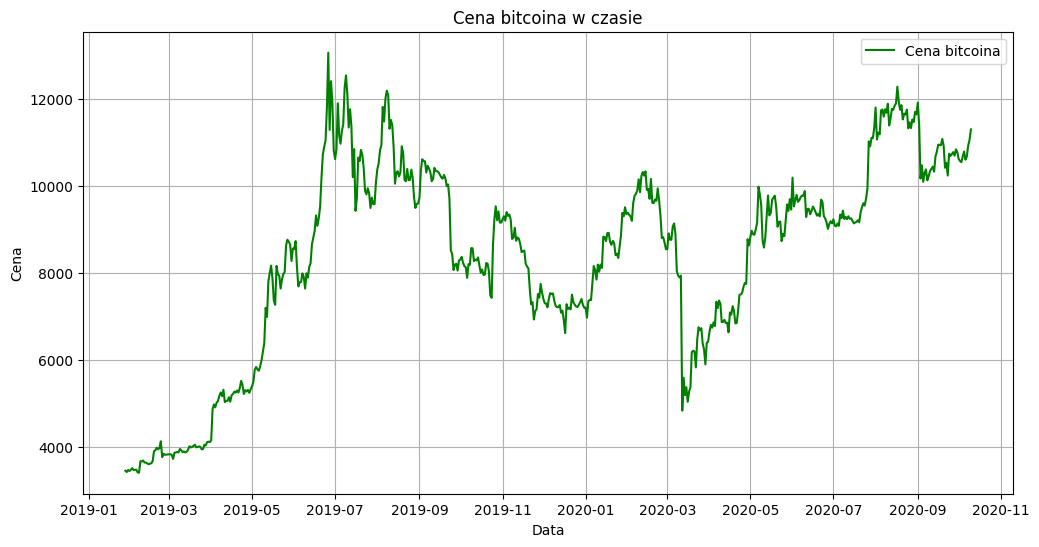

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize = (12, 6))
plt.plot(bitcoin.index, bitcoin["value"], label="Cena bitcoina", color="g")
plt.xlabel("Data")
plt.ylabel("Cena")
plt.title("Cena bitcoina w czasie")
plt.grid()
plt.legend()

plt.show()

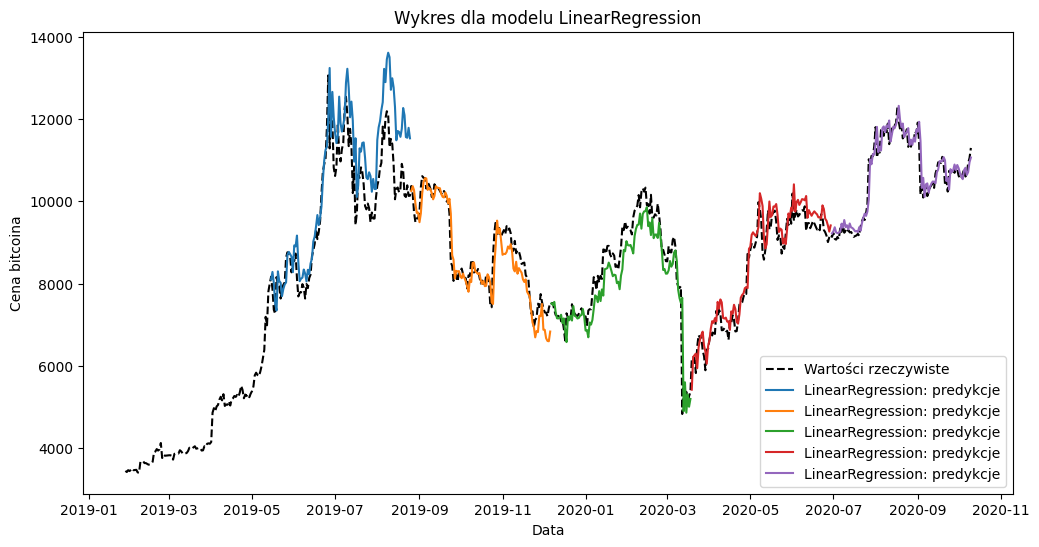

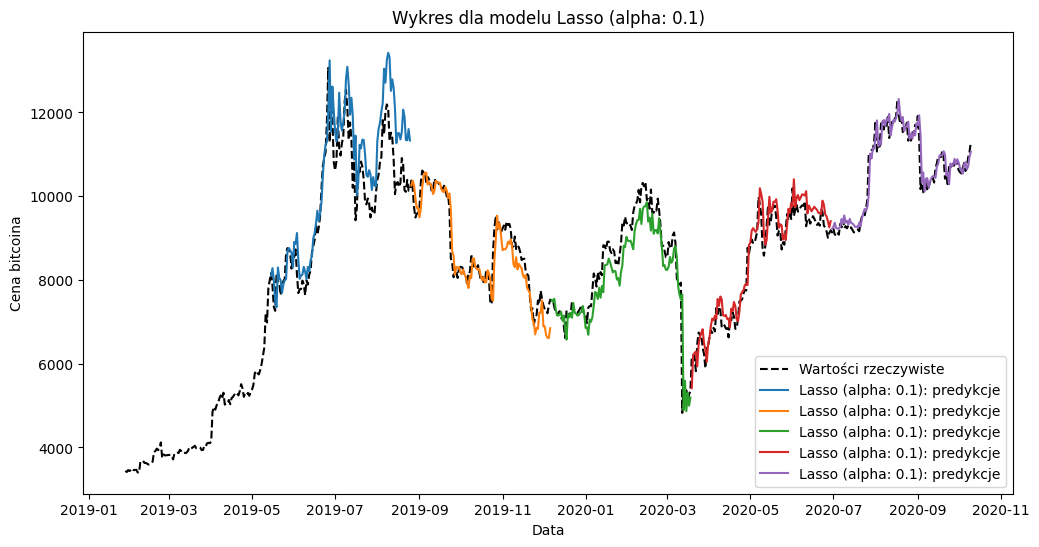

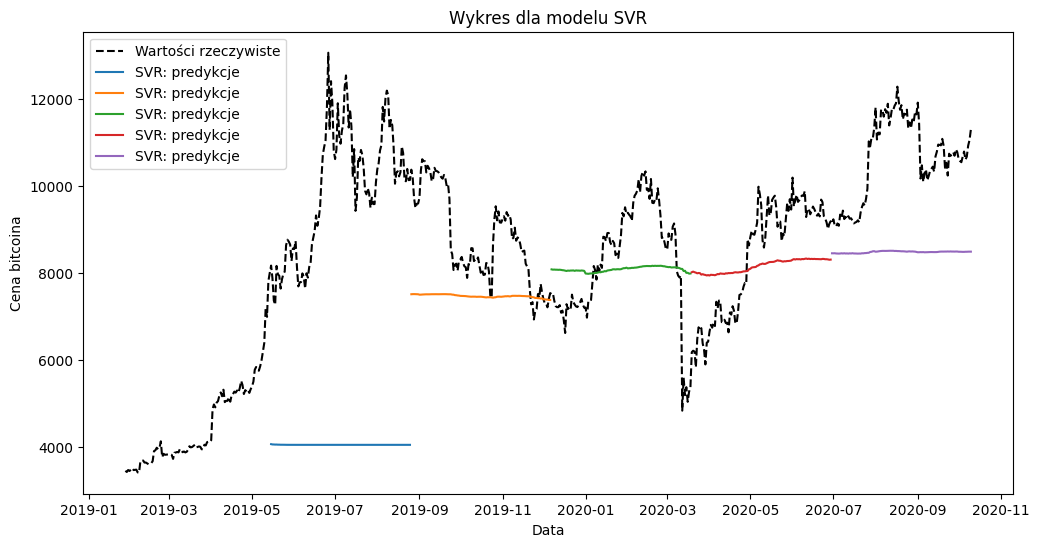

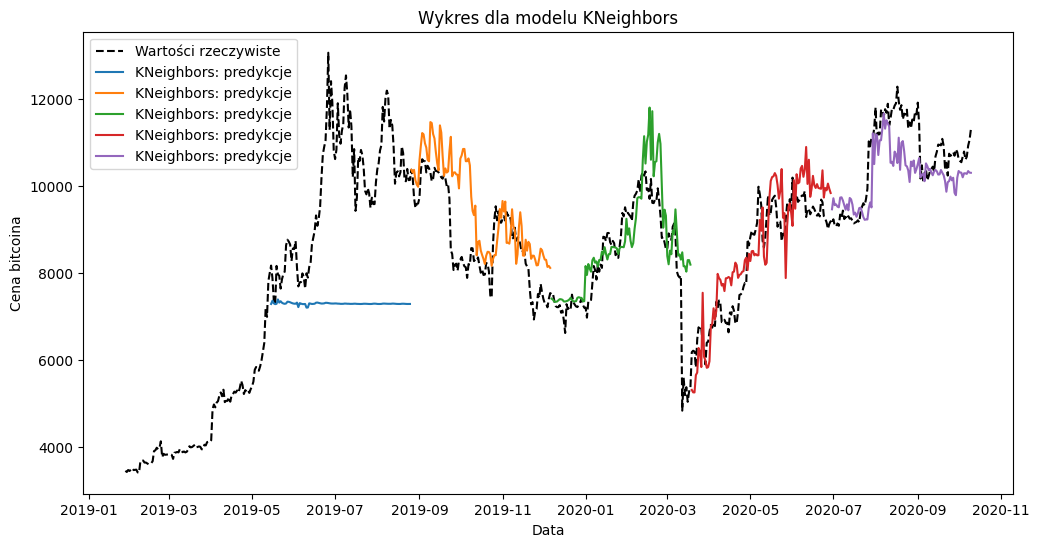

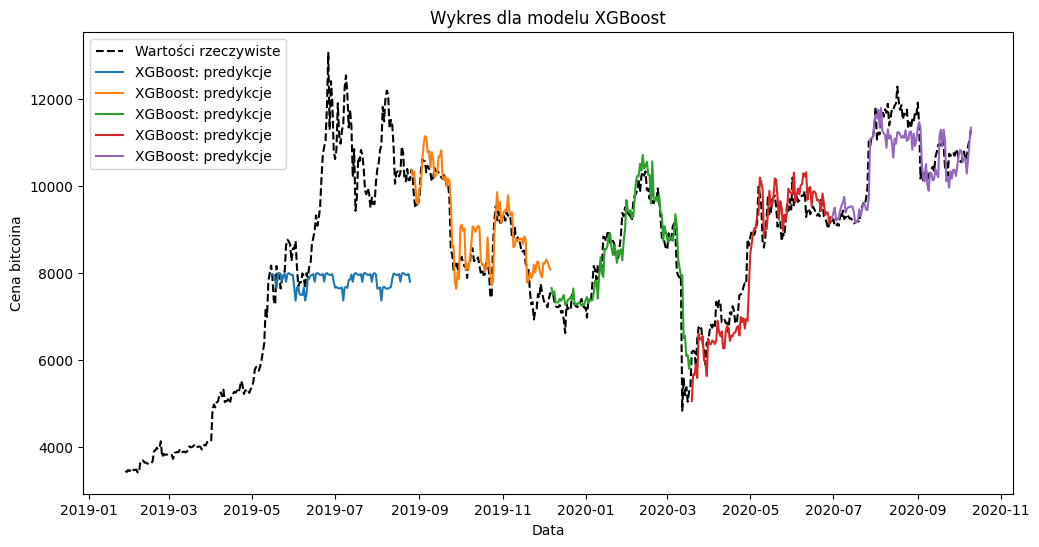

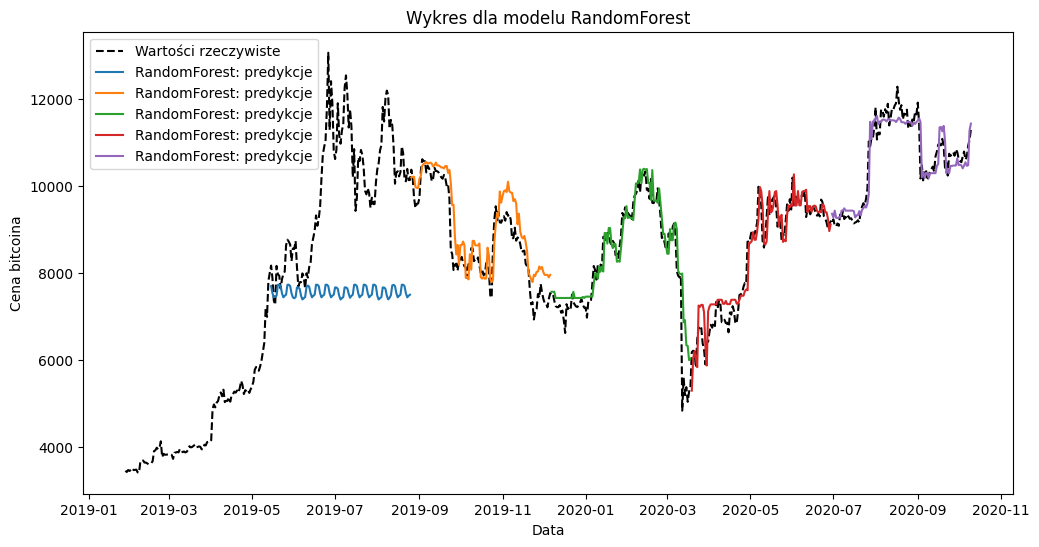

In [ ]:
def plot_predictions(model_name, predictions, y):
    fig, ax = plt.subplots(figsize = (12, 6))
    ax.plot(y.index, y, label="Wartości rzeczywiste", linestyle='dashed', color='black')

    for idx, y_pred in predictions:
        ax.plot(idx, y_pred, label=f"{model_name}: predykcje")

    ax.set_title(f"Wykres dla modelu {model_name}")
    ax.set_xlabel("Data")
    ax.set_ylabel("Cena bitcoina")
    ax.legend()

for name, preds in predictions.items():
    plot_predictions(name, preds, y)